# Отображатель графиков обучения

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K


class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()


plot = PlotLearning()



# Загружаем и исследуем датасет

170498071/170498071 [==============================] - 5s 0us/step


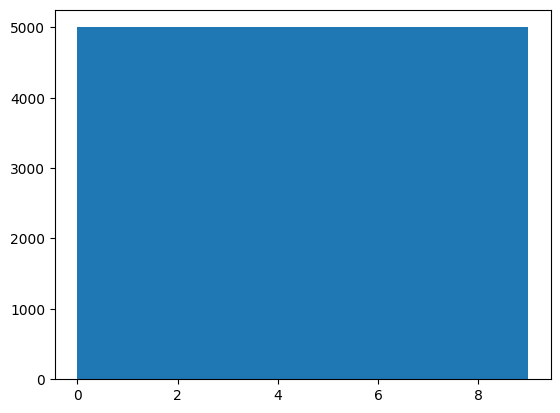

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
import numpy as np

num_classes = 10

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_cnn_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

plt.hist(y_train, num_classes)
plt.show()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train /= 255
x_test /= 255

# Создание и обучение модели
Создаем и обучаем сверточную сеть

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers

model = Sequential()
#model.add(Flatten(input_shape=(32,32,3)))

model.add(Conv2D(16, (3,3), input_shape=(32,32,3), padding='same'))
#model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(2,2))

for i in range(50):
    model.add(Conv2D(64,(3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

model.add(MaxPooling2D(2,2))
model.add(Flatten())

#model.add(Dense(32))
#model.add(ReLU())
#model.add(BatchNormalization())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate optimizer
opt = keras.optimizers.Adam(0.001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        9280      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       2

In [ ]:
#print('Not using data augmentation.')
batch_size = 64
epochs = 30
'''
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[plot]
          )
'''
print('Using data augmentation.')
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, callbacks=[plot])


Using data augmentation.


<ipython-input-4-03fa8a71113d>:48: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(datagen.flow(x_train, y_train,


Epoch 1/30
  4/782 [..............................] - ETA: 1:17:33 - loss: 3.2575 - accuracy: 0.1211

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

# Отображение результата
Отобразим результат распознавания 10 случайных тестовых изображений

          GT class           Predicted class
1/1 [==============================] - 0s 355ms/step


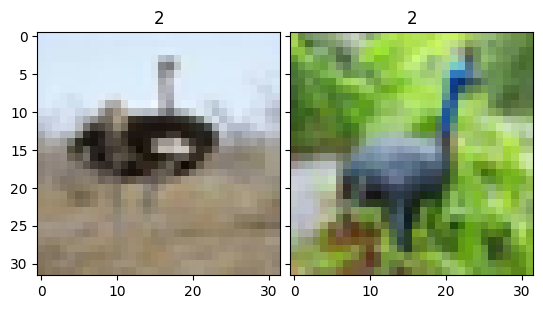

1/1 [==============================] - 0s 20ms/step


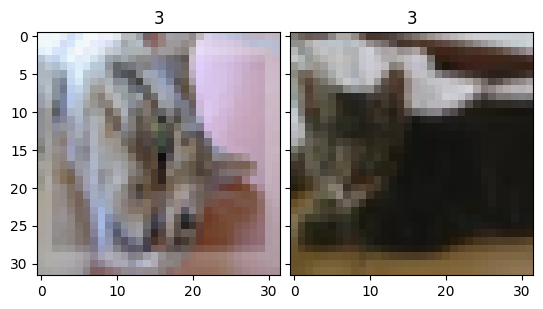

1/1 [==============================] - 0s 24ms/step


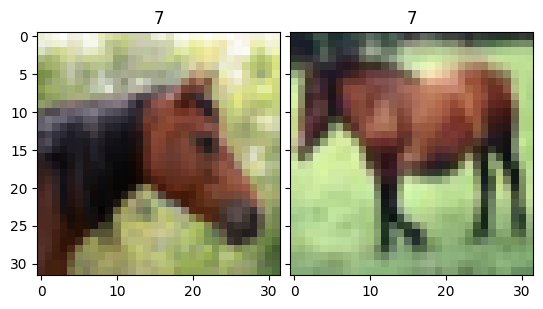

1/1 [==============================] - 0s 22ms/step


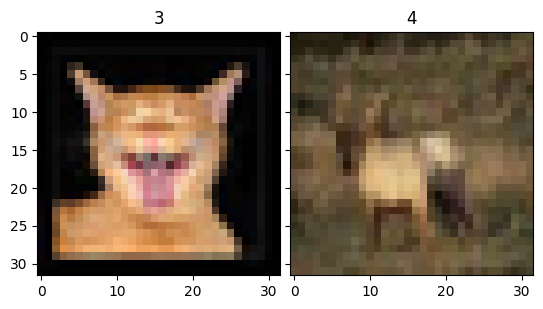

1/1 [==============================] - 0s 20ms/step


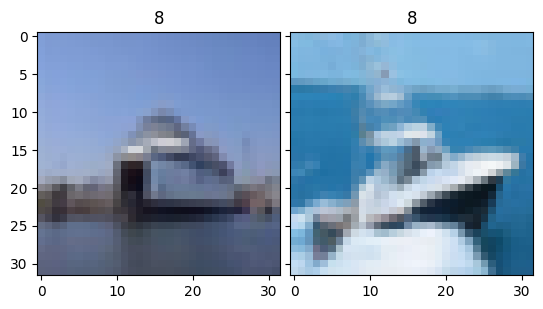

1/1 [==============================] - 0s 21ms/step


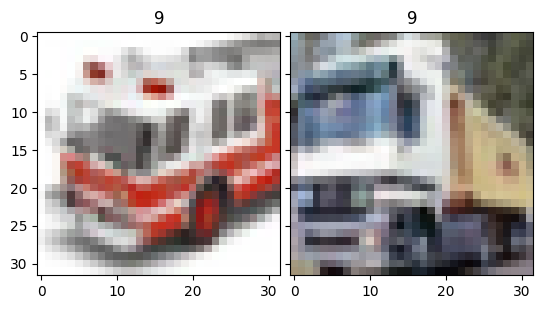

1/1 [==============================] - 0s 25ms/step


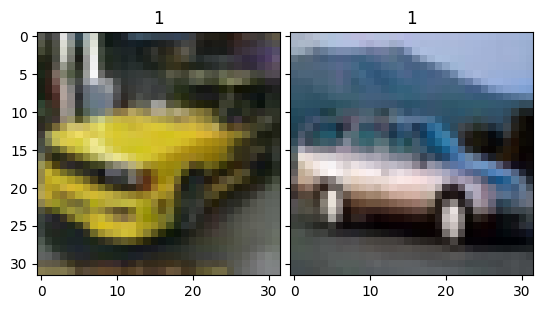

1/1 [==============================] - 0s 21ms/step


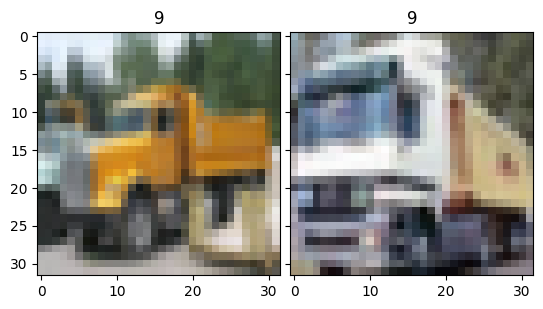

1/1 [==============================] - 0s 22ms/step


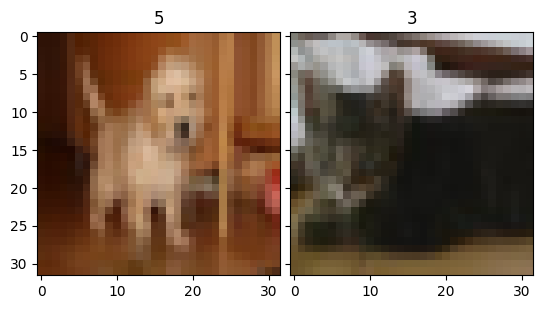

1/1 [==============================] - 0s 20ms/step


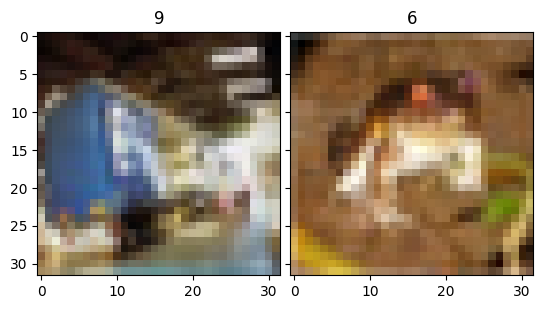

In [ ]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(32,32,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(32,32,3)))
    grid[1].set_title("{}".format(cls_name_pred))

    plt.show()



1/1 [==============================] - 0s 20ms/step


<Axes: >

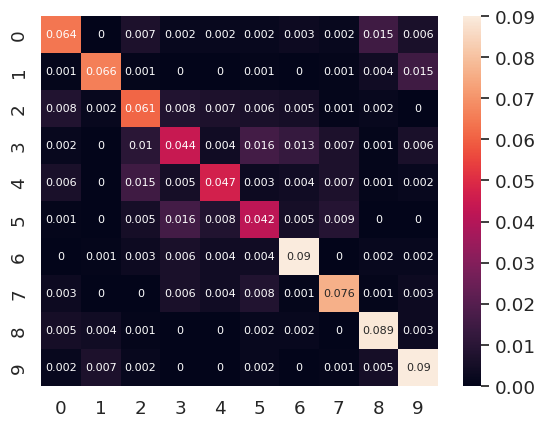

In [ ]:
import pandas as pd
import seaborn as sn

def get_conf_matrix(x_test, y_test):
    m = np.zeros((10,10))
    acc = 0
    i = 0
    for x in x_test:
        yp = np.argmax(model.predict(np.expand_dims(x, axis=0)))
        m[np.argmax(y_test[i]),yp] += 1
        i = i+1
    m = m/len(y_test)

    return m

m = get_conf_matrix(x_test[:1000], y_test[:1000])
df_cm = pd.DataFrame(m, range(10), range(10))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

Загрузим и классифицируем произвольное изображение

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bear.PNG  frog.PNG  mxnet1k.zip
(349, 368, 3)
1/1 [==============================] - 0s 29ms/step
[[7.6212925e-01 1.7605672e-02 1.5601627e-02 5.5760662e-03 1.0719129e-03
  3.7223563e-04 1.5589041e-01 9.2593700e-06 6.4212334e-04 4.1101418e-02]]


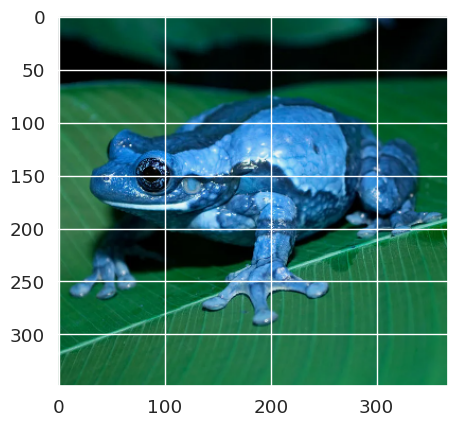

In [ ]:
import cv2
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/datasets

img = cv2.imread("/content/drive/MyDrive/datasets/frog.PNG")
print(img.shape)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img = img[...,::-1]
img = cv2.resize(img,(32,32))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))
print(y)